## Facial Filters

Using your trained facial keypoint detector, you can now do things like add filters to a person's face, automatically. In this optional notebook, you can play around with adding sunglasses to detected face's in an image by using the keypoints detected around a person's eyes. Checkout the `images/` directory to see what pther .png's have been provided for you to try, too!

<img src="images/face_filter_ex.png" width=60% height=60%/>

Let's start this process by looking at a sunglasses .png that we'll be working with!

In [1]:
# import necessary resources
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2

Image shape:  (1123, 3064, 4)


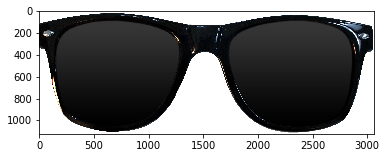

In [2]:
# load in sunglasses image with cv2 and IMREAD_UNCHANGED
sunglasses = cv2.imread('images/sunglasses.png', cv2.IMREAD_UNCHANGED)

# plot our image
plt.imshow(sunglasses)

# print out its dimensions
print('Image shape: ', sunglasses.shape)

## The 4th dimension

You'll note that this image actually has *4 color channels*, not just 3 as your avg RGB image does. This is due to the flag we set `cv2.IMREAD_UNCHANGED`, which tells this to read in another color channel.

#### Alpha channel
It has the usual red, blue, and green channels any color image has, and the 4th channel respresents the **transparency level of each pixel** in the image; this is often called the **alpha** channel. Here's how the transparency channel works: the lower the value, the more transparent, or see-through, the pixel will become.  The lower bound (completely transparent) is zero here, so any pixels set to 0 will not be seen; these look like white background pixels in the image above, but they are actually totally transparent. 

This transparent channel allows us to place this rectangular image of sunglasses on an image of a face and still see the face area that is techically covered by the transparentbackground of the sunglasses image!

Let's check out the alpha channel of our sunglasses image in the next Python cell. Because many of the pixels in the background of the image have an alpha value of 0, we'll need to explicitly print out non-zero values if we want to see them.

The alpha channel looks like this (black pixels = transparent): 


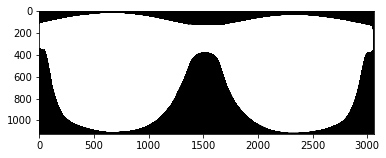

In [3]:
# print out the sunglasses transparency (alpha) channel
alpha_channel = sunglasses[:,:,3]
print ('The alpha channel looks like this (black pixels = transparent): ')
plt.imshow(alpha_channel, cmap='gray')

In [5]:
# just to double check that there are indeed non-zero values
# let's find and print out every value greater than zero
values = np.where(alpha_channel != 0)
print ('The non-zero values of the alpha channel are: ')
print (values)

The non-zero values of the alpha channel are: 
(array([  17,   17,   17, ..., 1109, 1109, 1109]), array([ 687,  688,  689, ..., 2376, 2377, 2378]))


#### Overlaying images

This means that when we place this sunglasses image on top of another image, we can use the transparency channel as a filter:

* If the pixels are non-transparent (alpha_channel > 0), overlay them on the new image

#### Keypoint locations

In doing this, it's helpful to understand which keypoint belongs to the eyes, mouth, etc., so in the image below we also print the index of each facial keypoint directly on the image so you can tell which keypoints are for the eyes, eyebrows, etc.,

<img src="images/landmarks_numbered.jpg" width=50% height=50%/>

It may be useful to use keypoints that correspond to the edges of the face to define the width of the sunglasses, and the locations of the eyes to define the placement.

Next, we'll load in an example image. Below, you've been given an image and set of keypoints from the provided training set of data, but you can use your own CNN model to generate keypoints for *any* image of a face (as in Notebook 3) and go through the same overlay process!

In [6]:
# load in training data
key_pts_frame = pd.read_csv('data/training_frames_keypoints.csv')

# print out some stats about the data
print('Number of images: ', key_pts_frame.shape[0])

Number of images:  3462


In [7]:
# helper function to display keypoints
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')


Image name:  Christopher_Walken_01.jpg


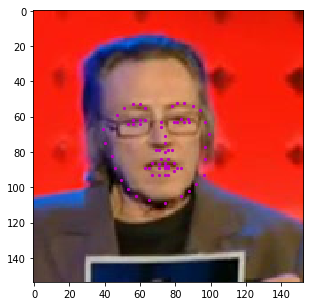

In [8]:
# a selected image
n = 120
image_name = key_pts_frame.iloc[n, 0]
image = mpimg.imread(os.path.join('data/training/', image_name))
key_pts = key_pts_frame.iloc[n, 1:].as_matrix()
key_pts = key_pts.astype('float').reshape(-1, 2)

print('Image name: ', image_name)

plt.figure(figsize=(5, 5))
show_keypoints(image, key_pts)
plt.show()

Next, you'll see an example of placing sunglasses on the person in the loaded image.

Note that the keypoints are numbered off-by-one in the numbered image above, and so `key_pts[0,:]` corresponds to the first point (1) in the labelled image.

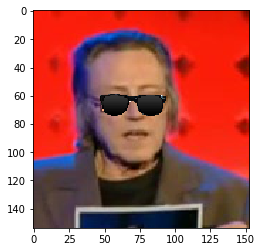

In [10]:
def overlay_sunglass(image, key_pts):
    # Display sunglasses on top of the image in the appropriate place

    # copy of the face image for overlay
    image_copy = np.copy(image)

    # top-left location for sunglasses to go
    # 17 = edge of left eyebrow
    x = int(key_pts[17, 0])
    y = int(key_pts[17, 1])

    # height and width of sunglasses
    # h = length of nose
    h = int(abs(key_pts[27,1] - key_pts[34,1]))
    # w = left to right eyebrow edges
    w = int(abs(key_pts[17,0] - key_pts[26,0]))

    # read in sunglasses
    sunglasses = cv2.imread('images/sunglasses.png', cv2.IMREAD_UNCHANGED)
    # resize sunglasses
    new_sunglasses =  cv2.resize(sunglasses, (w, h), interpolation = cv2.INTER_CUBIC)

    # get region of interest on the face to change
    roi_color = image_copy[y:y+h,x:x+w]

    # find all non-transparent pts
    ind = np.argwhere(new_sunglasses[:,:,3] > 0)

    # for each non-transparent point, replace the original image pixel with that of the new_sunglasses
    for i in range(3):
        roi_color[ind[:,0],ind[:,1],i] = new_sunglasses[ind[:,0],ind[:,1],i]    
    # set the area of the image to the changed region with sunglasses
    image_copy[y:y+h,x:x+w] = roi_color


    # display the result!
    plt.imshow(image_copy)
    
    
overlay_sunglass(image, key_pts)

#### Further steps

Look in the `images/` directory to see other available .png's for overlay! Also, you may notice that the overlay of the sunglasses is not entirely perfect; you're encouraged to play around with the scale of the width and height of the glasses and investigate how to perform [image rotation](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html) in OpenCV so as to match an overlay with any facial pose.

2406


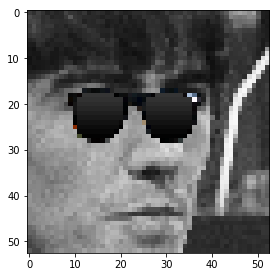

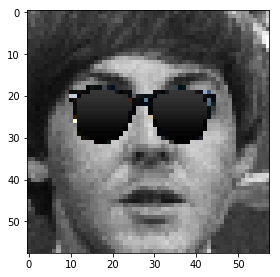

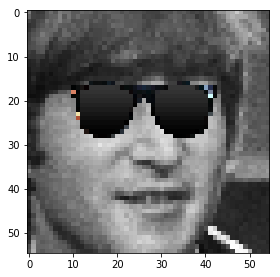

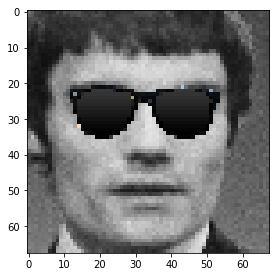

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#######################

import cv2
# load in color image for face detection
image = cv2.imread('images/the_beatles.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(image.shape[0])
w,h = (image.shape[0], image.shape[1])

image = cv2.resize(image, (600, int(600 * w / h)))

#######################

# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 
    
    
########################
import torch
from models import Net

net = Net()

## TODO: load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model
net.load_state_dict(torch.load('saved_models/keypoints_model_final.pt'))

## print out your net and prepare it for testing (uncomment the line below)
net.eval()


###########################
from torch.autograd import Variable
from torchvision import transforms, utils
from data_load import Rescale, RandomCrop, Normalize, ToTensor

image_copy = np.copy(image)

face_images = []
face_images_color = []
# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces:
    
    padding = 0
    
    y_start = max(y - padding, 0)
    y_end = y + h + padding
    
    x_start = max(x - padding, 0)
    x_end = x + w + padding
    
    # Select the region of interest that is the face in the image 
    roi_color = image_copy[y_start:y_end, x_start:x_end]
    
    ## TODO: Convert the face region from RGB to grayscale
    roi = cv2.cvtColor(roi_color, cv2.COLOR_RGB2GRAY)

    ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]    
    roi = roi/255.0

    ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    roi = cv2.resize(roi, (224, 224))
    
#     crop_size = 224
#     top = np.random.randint(0, rescale_size - crop_size)
#     left = np.random.randint(0, rescale_size - crop_size)

#     roi = roi[top: top + crop_size,
#               left: left + crop_size]
    
    
    ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    roi = roi.reshape(roi.shape[0], roi.shape[1], 1)
    roi = roi.transpose((2, 0, 1))
    roi = torch.from_numpy(roi)
    
    face_images.append(roi)
    face_images_color.append(roi_color)

    
## TODO: Make facial keypoint predictions using your loaded, trained network 
## perform a forward pass to get the predicted facial keypoints
images_tensors = torch.stack(face_images).type(torch.FloatTensor)
output_pts = net(Variable(images_tensors))
output_pts = output_pts.view(output_pts.size()[0], 68, -1)


def restore_keypoints(pts, crop=224):
    return pts*(crop/2) + (crop/2)

## TODO: Display each detected face and the corresponding keypoints        
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')
        
def visualize_output(images, outputs):
    count = len(images)
    
    for i in range(count):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, count, i+1)

        img = images[i]

        predicted_key_pts = outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        predicted_key_pts = restore_keypoints(predicted_key_pts)
        predicted_key_pts = predicted_key_pts / (224/img.shape[0])

        # show_all_keypoints(np.squeeze(img), predicted_key_pts)
        
        overlay_sunglass(img, predicted_key_pts)

    plt.show()

visualize_output(face_images_color, output_pts)

